# Particle tracking with MODFLOW 6 and MODPATH 7

A model is "solved" once convergence is achieved for steady state or transient head values. As we've seen in the class so far, this means we can create outputs that show changes in head over time at points in space or throughout the model domain.

Often, however, the prediction of interest for a model is something different than head values at a point in space. For example, we may want to know how quickly a lake is losing water to pumping, and how that changes as pumping rates change. Or, we may want to understand the source for water entering a particular region (such as the source of water entering a well).

Thes notebook demonstrates particle tracking with MODFLOW 6 using the associated particle tracking code MODPATH 7.

**Notes**:
The codes that can be used for particle tracking are in a bit of "flux" (pun intended), with new capabilities for MODFLOW 6 actively being developed. The following provides some guidelines on how to handle particle tracking with current and historical models:

* MODFLOW-2005: Users of MODFLOW-2005 must use MODPATH 6, with associated functions found under `flopy.modpath.mp6`.
* MODFLOW 6:
   * For rectangular / plaid grids or quadtree grids, MODPATH 7 can be used.
   * For more unstructured grids, the MODFLOW 6 PRT (Particle tracking) provides a more flexible method for particle tracking. However, note that this was only recently released (May 23, 2024), and the most recent release of MODFLOW 6 version 6.6 indicates that [there are many bugs still being squashed](https://water.usgs.gov/water-resources/software/MODFLOW-6/release_6.6.0.pdf)

This notebook is a simplified version of the 2024 [MODFLOW training notebooks](https://github.com/christianlangevin/modflow-training-princeton2024/tree/main/examples/notebooks) offered by Christian Langevin.

## Learning Objectives

After you have read and run this notebook, you should be able to:
* Setup MODPATH 7 to run using the results from a MODFLOW 6 model
* Define options for particle tracking including particle release locations, particle travel directions, and MODPATH output

## Initial Setup

As usual, we will import all necessary packages used in this workbook first.

In [1]:
#Note - Pathlib is an alternative to os.path
import pathlib as pl

import flopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from flopy.utils.gridgen import Gridgen
from flopy.utils.gridintersect import GridIntersect
from flopy.discretization import VertexGrid
from flopy.utils.triangle import Triangle as Triangle
from flopy.utils.voronoi import VoronoiGrid
from shapely.geometry import LineString, Point, MultiPoint, Polygon
from matplotlib import colormaps as cm

Define the base workspace.

In [2]:
example_name = "tracking"
base_ws = pl.Path("nboutput") / example_name

### MODPATH 7 Example Problem 2

This problem is reproduced from the MODPATH 7 user guide examples
document ([Pollock, 2016](http://dx.doi.org/10.3133/ofr20161086)).

The flow system consists of two aquifers with a low conductivity
confining layer in between. The model grid is roughly square. There is
a quad-refined region around a central well and a river runs along the
grid's eastern boundary.

Particles are released from the four lateral faces of the well and tracked
backwards to recharge points at the water table.


#### Grid refinement

Our first step is to create a quad-refined grid. For this we will use the [GRIDGEN](https://www.usgs.gov/software/gridgen-program-generating-unstructured-finite-volume-grids) program.

The grid will have 3 refinement levels. First we create a "dummy" structured grid discretization to use as a base for refinement.

In [3]:
# Base grid properties
Lx = 10000.0
Ly = 10500.0
nlay = 3
nrow = 21
ncol = 20
delr = Lx / ncol
delc = Ly / nrow
top = 400
botm = [220, 200, 0]

In [4]:
# Create a "dummy" discretization
ms = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

We are now ready to refine the grid.

In [5]:
# Create gridgen workspace and object
gridgen_ws = base_ws / "gridgen"
gridgen_ws.mkdir(parents=True, exist_ok=True)
gridgen = Gridgen(ms.modelgrid, model_ws=gridgen_ws)

In [6]:
# Define refinement polygons
ref_polys = [
    [[(3500, 4000), (3500, 6500), (6000, 6500), (6000, 4000), (3500, 4000)]],  # outer
    [[(4000, 4500), (4000, 6000), (5500, 6000), (5500, 4500), (4000, 4500)]],  # middle
    [[(4500, 5000), (4500, 5500), (5000, 5500), (5000, 5000), (4500, 5000)]],  # inner
]
ref_paths = []
for i, poly in enumerate(ref_polys):
    gridgen.add_refinement_features([poly], "polygon", i + 1, range(nlay))
    ref_paths.append(gridgen_ws / f"rf{i}")

In [7]:
# Build the refined grid
gridgen.build(verbose=False)
grid_props = gridgen.get_gridprops_vertexgrid()
disv_props = gridgen.get_gridprops_disv()
grid = flopy.discretization.VertexGrid(**grid_props)

In [8]:
# Extract refined grid properties
ncpl = disv_props["ncpl"]
top = disv_props["top"]
botm = disv_props["botm"]
nvert = disv_props["nvert"]
vertices = disv_props["vertices"]
cell2d = disv_props["cell2d"]

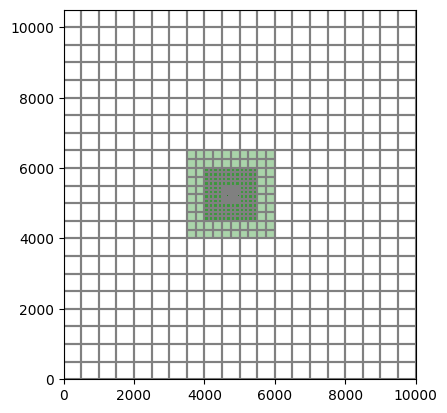

In [9]:
# Plot the grid with refinement levels superimposed.
grid.plot()
for i, path in enumerate(ref_paths):
    flopy.plot.plot_shapefile(path, ax=plt.gca(), facecolor="green", edgecolor="none", alpha=(i + 1) / 3)
plt.show()

#### Groundwater flow model

We are ready to create the GWF model. First, define the model name, workspace, units, and some parameters.

Define the model name and workspace.

In [10]:
gwf_name = f"{example_name}-gwf"
gwf_ws = base_ws / "gwf"
gwf_ws.mkdir(exist_ok=True, parents=True)

Define model units.

In [11]:
length_units = "feet"
time_units = "days"

Define model parameters.

In [12]:
nper = 1  # Number of periods
nlay = 3  # Number of layers (base grid)
nrow = 21  # Number of rows (base grid)
ncol = 20  # Number of columns (base grid)
delr = 500.0  # Column width ($ft$)
delc = 500.0  # Row width ($ft$)
top = 400.0  # Top of the model ($ft$)
botm = [220.0, 200.0, 0.0]  # Layer bottom elevations ($ft$)
porosity = 0.1  # Soil porosity (unitless)
rrch = 0.005  # Recharge rate ($ft/d$)
kh = [50.0, 0.01, 200.0]  # Horizontal hydraulic conductivity ($ft/d$)
kv = [10.0, 0.01, 20.0]  # Vertical hydraulic conductivity ($ft/d$)
wel_q = -150000.0  # Well pumping rate ($ft^3/d$)
riv_h = 320.0  # River stage ($ft$)
riv_z = 317.0  # River bottom ($ft$)
riv_c = 1.0e5  # River conductance ($ft^2/d$)

Define the time discretization.

In [13]:
nstp = 1
perlen = 1000.0
tsmult = 1.0
tdis_rc = [(perlen, nstp, tsmult)]

Now we can begin to construct the GWF model.

In [14]:
sim = flopy.mf6.MFSimulation(
    sim_name=gwf_name, exe_name="mf6", version="mf6", sim_ws=gwf_ws
)
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", perioddata=tdis_rc, nper=len(tdis_rc)
)
gwf = flopy.mf6.ModflowGwf(
    sim, modelname=gwf_name, model_nam_file="{}.nam".format(gwf_name)
)
gwf.name_file.save_flows = True
disv = flopy.mf6.ModflowGwfdisv(
    gwf,
    length_units=length_units,
    **disv_props,  # from grid refinement above
)
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=riv_h)  # initial heads at river stage
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    xt3doptions=[("xt3d")],
    icelltype=[1, 0, 0],
    k=kh,
    k33=kv,
    save_saturation=True,
    save_specific_discharge=True,
)

Define the model's boundary conditions. These include a well, a river, and recharge. Instead of manually setting cell IDs for the well and river, we will determine cell IDs by defining boundary coordinates and intersecting them with the grid.

In [15]:
# Create intersection object
ix = GridIntersect(gwf.modelgrid, method="vertex", rtree=True)

In [16]:
# Create the well package
wel_coords = [(4718.45, 5281.25)]
welcells = ix.intersects(MultiPoint(wel_coords))
welcells = [icpl for (icpl,) in welcells]
welspd = [[(2, icpl), -150000.0] for icpl in welcells]
wel = flopy.mf6.ModflowGwfwel(gwf, print_input=True, stress_period_data=welspd)

In [17]:
# Create the river package
riv_iface = 6
riv_iflowface = -1
riverline = [(Lx - 1.0, Ly), (Lx - 1.0, 0.0)]
rivcells = ix.intersects(LineString(riverline))
#Clever? Why not
rivcells = rivcells.cellids.tolist()
#Old code!
#rivcells = [icpl for (icpl,) in rivcells]
rivspd = [
    [(0, icpl), riv_h, riv_c, riv_z] for icpl in rivcells
]
print(rivspd)
riv = flopy.mf6.ModflowGwfriv(
    gwf, stress_period_data=rivspd
)

[[(0, 650), 320.0, 100000.0, 317.0], [(0, 630), 320.0, 100000.0, 317.0], [(0, 610), 320.0, 100000.0, 317.0], [(0, 590), 320.0, 100000.0, 317.0], [(0, 570), 320.0, 100000.0, 317.0], [(0, 550), 320.0, 100000.0, 317.0], [(0, 530), 320.0, 100000.0, 317.0], [(0, 510), 320.0, 100000.0, 317.0], [(0, 490), 320.0, 100000.0, 317.0], [(0, 455), 320.0, 100000.0, 317.0], [(0, 384), 320.0, 100000.0, 317.0], [(0, 265), 320.0, 100000.0, 317.0], [(0, 194), 320.0, 100000.0, 317.0], [(0, 159), 320.0, 100000.0, 317.0], [(0, 139), 320.0, 100000.0, 317.0], [(0, 119), 320.0, 100000.0, 317.0], [(0, 99), 320.0, 100000.0, 317.0], [(0, 79), 320.0, 100000.0, 317.0], [(0, 59), 320.0, 100000.0, 317.0], [(0, 39), 320.0, 100000.0, 317.0], [(0, 19), 320.0, 100000.0, 317.0]]


In [18]:
# Create the recharge package
rch = flopy.mf6.ModflowGwfrcha(
    gwf,
    recharge=rrch,
#    auxiliary=["iface", "iflowface"],
#    aux=[rch_iface, rch_iflowface],
)

Finally we can create the output control and solver packages.

In [19]:
# Create the output control package
headfile_name = "{}.hds".format(gwf_name)
budgetfile_name = "{}.cbb".format(gwf_name)
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    pname="oc",
    budget_filerecord=[budgetfile_name],
    head_filerecord=[headfile_name],
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

In [20]:
# Create the iterative model solution (IMS) package and register it with the model.
ims = flopy.mf6.ModflowIms(
    sim,
    pname="ims",
    outer_dvclose=1.0e-5,
    outer_maximum=100,
    under_relaxation="NONE",
    inner_maximum=100,
    inner_dvclose=1.0e-6,
    rcloserecord=0.1,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=0.99,
)
sim.register_ims_package(ims, [gwf.name])

We can now write and run the GWF simulation.

In [21]:
sim.write_simulation(silent=False)
sim.run_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model tracking-gwf...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../../../opt/anaconda3/envs/geosci724/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/20/2024

        MODFLOW 6 compiled Dec 23 2024 16:29:44 with GCC version 12.4.0

This software has been approved for release by the 

(True, [])

Load head output from the flow model.

In [22]:
hds = gwf.output.head().get_data()

Plot the heads.

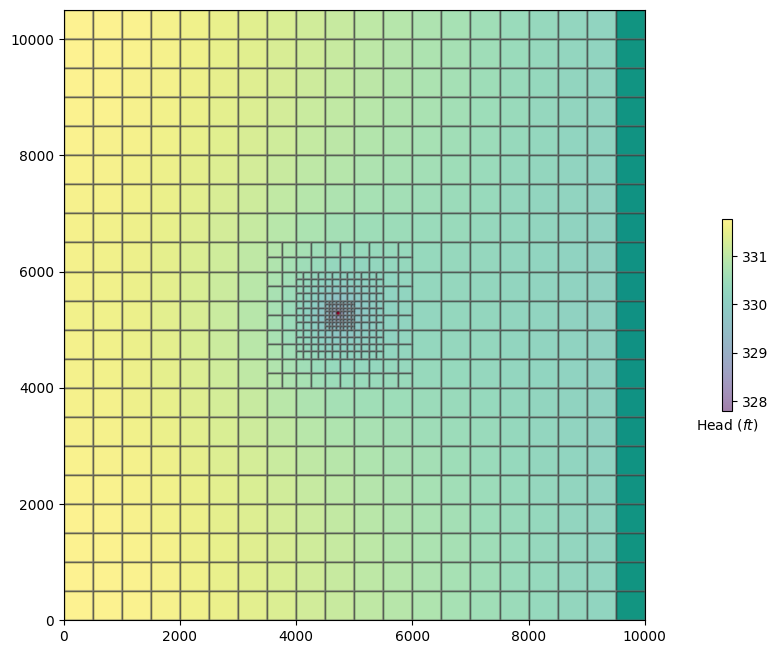

In [23]:
fig = plt.figure(figsize=(10, 10))
fig.tight_layout()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(gwf, ax=ax, layer=2)
mm.plot_grid(alpha=0.25)
mm.plot_bc("WEL", plotAll=True, color="red")
mm.plot_bc("RIV", plotAll=True, color="teal")
pc = mm.plot_array(hds[:, 0, :], edgecolor="black", alpha=0.5)
cb = plt.colorbar(pc, shrink=0.25, pad=0.1)
cb.ax.set_xlabel(r"Head ($ft$)")
plt.show()

#### MODPATH 7 Model

Next, we can create a MODPATH 7 particle tracking model using the flow model we just created. The first step is to define the particle release configuration. We distribute particles evenly around the 4 lateral faces of the well.

In [24]:
face_data = flopy.modpath.FaceDataType(
    rowdivisions5=0,
    columndivisions5=0,
    rowdivisions6=0,
    columndivisions6=0
)
particle_data = flopy.modpath.NodeParticleData(
    nodes=ncpl * 2 + welcells[0],
    subdivisiondata=None
)

# particle_data2 = flopy.modpath.ParticleData(
#     partlocs=[ncpl * 2 + welcells[0]],
# )

particle_group = flopy.modpath.ParticleGroupNodeTemplate(
    particlegroupname="PG",
    particledata=particle_data,
    filename="pg.sloc",
)

# particle_group2 = flopy.modpath.ParticleGroupLRCTemplate(
#     particlegroupname="PG",
#     particledata=particle_data2,
#     filename="pg2.sloc",
# )

Now define the model name and workspace.

In [25]:
mp7_name = f"{example_name}-mp7"
mp7_ws = base_ws / "mp7"
mp7_ws.mkdir(exist_ok=True, parents=True)

Build the MP7 model.

In [26]:
mp7_sim = flopy.modpath.Modpath7(
    modelname=mp7_name,
    flowmodel=gwf,
    exe_name="mp7",
    model_ws=mp7_ws,
    budgetfilename=budgetfile_name,
    headfilename=headfile_name,
)

In [27]:
mp7_bas = flopy.modpath.Modpath7Bas(mp7_sim, porosity=porosity)

In [28]:
mp7 = flopy.modpath.Modpath7Sim(
    mp7_sim,
    simulationtype="combined",
    trackingdirection="backward",
    weaksinkoption="pass_through",
    weaksourceoption="pass_through",
    referencetime=0.0,
    stoptimeoption="extend",
    timepointdata=[500, 1000.0],
    particlegroups=[particle_group],
)

Write and run the MP7 model.

In [29]:
mp7_sim.write_input()
mp7_sim.run_model(silent=False)

FloPy is using the following executable to run the model: ../../../../../../../../opt/anaconda3/envs/geosci724/bin/mp7

MODPATH Version 7.2.001   
Program compiled Feb 14 2025 13:41:09 with GFORTRAN compiler (ver. 12.4.0)      


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+03  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        27 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                 

(True, [])

Load pathlines from the MP7 pathline output file.

In [30]:
mp7_pathline_file = flopy.utils.PathlineFile(mp7_ws / f"{mp7_name}.mppth")
mp7_pathlines = pd.DataFrame(
    mp7_pathline_file.get_destination_pathline_data(
        list(range(gwf.modelgrid.nnodes)), to_recarray=True
    )
)

Plot MP7 pathlines in plan view.

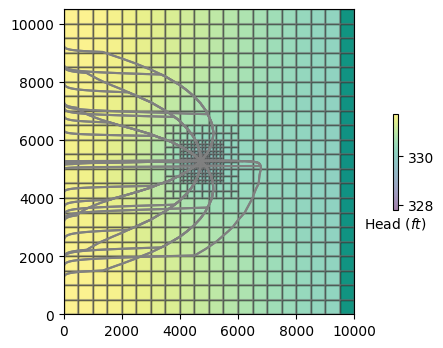

In [31]:
fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(gwf, ax=ax, layer=2)
mm.plot_grid(alpha=0.25)
mm.plot_bc("WEL", plotAll=True, color="red")
mm.plot_bc("RIV", plotAll=True, color="teal")
pc = mm.plot_array(hds[:, 0, :], edgecolor="black", alpha=0.5)
cb = plt.colorbar(pc, shrink=0.25, pad=0.1)
cb.ax.set_xlabel(r"Head ($ft$)")
mm.plot_pathline(mp7_pathlines, layer="all")
plt.show()

Next we can create a 3D pathline plot. The first step is to export results to VTK and convert them to PyVista meshes.